# SBA Loan Approval Analysis
## Project 2
### Mohammad Mahdavi (MXM220107)

## Data Cleaning

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 1500)

import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [28]:
#Load the dataset
SBA_df = pd.read_csv("SBA_loans_project_2.csv")

In [96]:
SBA_df.head(5)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Region,NAICS_sector,NAICS_subsector,NAICS_industry_group,SBA_Guarantee_Ratio,LoanSizeCategory,sqrt_DisbursementGross,sqrt_GrAppv,sqrt_SBA_Appv,exp_NoEmp,NoEmp_RetainedJob
0,0,NEW YORK,NY,10003,JPMORGAN CHASE BANK NATL ASSOC,IL,561439,9,Existing,1,9,1,Urban,Missing,N,68000.0,0.0,68000.0,34000.0,0,Northeast,56,561,5614,0.50,Medium,260.768096,260.768096,184.390889,8103.083928,81
1,1,PAWTUCKET,RI,2860,CITIZENS BANK NATL ASSOC,RI,541810,8,Existing,4,12,0,Urban,N,N,90000.0,0.0,90000.0,45000.0,1,Northeast,54,541,5418,0.50,Medium,300.000000,300.000000,212.132034,2980.957987,96
2,2,ISSAQUAH,WA,98027,FIRST-CITIZENS BK & TR CO,WA,448210,9,New,0,0,1,Undefined,N,N,450000.0,0.0,450000.0,337500.0,0,West,44,448,4482,0.75,Large,670.820393,670.820393,580.947502,8103.083928,0
3,3,HURST,TX,76053,WILSHIRE BANK,CA,722213,4,Existing,0,4,1,Urban,Missing,N,140000.0,0.0,165000.0,82500.0,0,South,72,722,7222,0.50,Medium,374.165739,406.201920,287.228132,54.598150,16
4,4,ALPINE,CA,91901,CALIFORNIA BANK & TRUST,CA,233210,1,Existing,0,1,1,Rural,Y,N,50000.0,0.0,50000.0,25000.0,0,West,23,233,2332,0.50,Small,223.606798,223.606798,158.113883,2.718282,1


### Cleaning the `LowDoc` Column
The `LowDoc` column, which indicates whether a loan was processed under the streamlined "Low Documentation" program, originally contained a mix of expected ('Y', 'N') and unexpected values (such as 'S', 'R', 'A', 'C', 0, '0', '1'). To clean this data:

1. We identified all non-standard entries that were not 'Y' or 'N'.
2. For loans with a `DisbursementGross` over a 150,000, it was assumed that full documentation would be required, and thus these non-standard or missing entries were set to 'N'. 
3. For loans with a `DisbursementGross` of 150,000 or less, the streamlined 'LowDoc' application process was likely used, and these entries were set to 'Y'.

This approach ensured that the `LowDoc` column accurately reflects the type of loan documentation used, which is crucial for subsequent analysis and modeling.

In [29]:
# Identify all unique values in 'LowDoc' that are not 'Y' or 'N'
unique_entries = SBA_df['LowDoc'].unique()
LowDoc_error = [entry for entry in unique_entries if entry not in ['Y', 'N']]

# Create a mask for rows where 'LowDoc' is an error or missing
error_or_missing_mask = SBA_df['LowDoc'].isin(LowDoc_error) | SBA_df['LowDoc'].isna()

# Update 'LowDoc' based on 'DisbursementGross' where the mask is True
SBA_df.loc[error_or_missing_mask & (SBA_df['DisbursementGross'] > 150000), 'LowDoc'] = 'N'
SBA_df.loc[error_or_missing_mask & (SBA_df['DisbursementGross'] <= 150000), 'LowDoc'] = 'Y'

# Print the unique values in 'LowDoc' before and after the operation to confirm it contains only 'Y' or 'N'
print('LowDoc Column Entries Before Cleaning:', LowDoc_error)
print('LowDoc Column Entries After Cleaning:', SBA_df['LowDoc'].unique())

LowDoc Column Entries Before Cleaning: ['0', nan, 'C', 'A', 'S', 'R', '1']
LowDoc Column Entries After Cleaning: ['N' 'Y']


### Cleaning the `RevLineCr` Column

The `RevLineCr` column represents whether there is a revolving line of credit ('Y' for Yes, 'N' for No). Entries not marked as 'Y' or 'N' are considered inconsistent with the expected data format. To address this:

- Entries not conforming to 'Y' or 'N' were classified as 'Unknown'.
- This step ensures the data consistency necessary for accurate analysis, treating anomalies uniformly.

In [30]:
# Find and replace values in 'RevLineCr' that are not 'Y' or 'N'
RevLineCr_error = SBA_df['RevLineCr'][~SBA_df['RevLineCr'].isin(['Y', 'N'])].unique()
SBA_df['RevLineCr'].replace(RevLineCr_error, 'Missing', inplace=True)

# Print the unique values in 'LowDoc' before and after the operation to confirm it contains only 'Y' or 'N'
print('RevLineCr Column Entries Before Cleaning:', RevLineCr_error)
print('RevLineCr Column Entries After Cleaning:', SBA_df['RevLineCr'].unique())

RevLineCr Column Entries Before Cleaning: ['0' 'T' nan '1' 'A' '`' '4' 'R' '2' '.' '5' 'C' ',' '-' 'Q' '7' '3']
RevLineCr Column Entries After Cleaning: ['Missing' 'N' 'Y']


### Cleaning the `NewExist` Column

The `NewExist` column indicates the status of the business where 1 represents existing businesses and 2 denotes new ones. Let's replaces the numeric codes with more descriptive labels

In [31]:
# Replace numerical values with strings in 'NewExist' column
SBA_df['NewExist'].replace({1.0: 'Existing', 2.0: 'New', 0.0: 'Missing'}, inplace=True)

# Print the unique values in 'NewExist' after the operation
print('NewExist Column Entries After Cleaning:', SBA_df['NewExist'].unique())

NewExist Column Entries After Cleaning: ['Existing' 'New' 'Missing' nan]


### Cleaning the `UrbanRural` Column

The `UrbanRural` column categorizes the location of the business into three distinct types:
- **1** represents an **Urban** area,
- **2** signifies a **Rural** area,
- **0** is used when the area is **Undefined** or the information is missing.

In [32]:
# Replace numerical values with strings in 'UrbanRural' column
SBA_df['UrbanRural'].replace({1.0: 'Urban', 2.0: 'Rural', 0.0: 'Undefined'}, inplace=True)

# Print the unique values in 'UrbanRural' after the operation
print('UrbanRural Column Entries After Cleaning:', SBA_df['UrbanRural'].unique())

UrbanRural Column Entries After Cleaning: ['Urban' 'Undefined' 'Rural']


### Missing Value Imputation

Categorical missing values are imputed with 'Missing', providing a clear placeholder for where data is absent. For numerical features, we replace missing values with the column mean, maintaining the distribution and central tendency of the dataset.

In [33]:
# Fill missing values for categorical features with 'Missing'
cat_cols = SBA_df.select_dtypes(include=['object']).columns
cat_cols_missing = cat_cols[SBA_df[cat_cols].isnull().any()]
SBA_df[cat_cols_missing] = SBA_df[cat_cols_missing].fillna('Missing')

# Fill missing values for numerical features with their mean
num_cols = SBA_df.select_dtypes(include=[np.number]).columns
num_cols_missing = num_cols[SBA_df[num_cols].isnull().any()]
for col in num_cols_missing:
    SBA_df[col] = SBA_df[col].fillna(SBA_df[col].mean())


## Feature Engineering

#### Zip Code to Region Mapping
Generates a new feature 'Region' by categorizing zip codes into 'Northeast', 'Midwest', 'South', 'West', or 'Unknown'.


In [34]:
def custom_zipcode_binning(zipcode_str):
    # Convert the integer to a string to use subscripting
    zipcode_str = str(zipcode_str)
    # Now you can take the first digit to determine the region
    region = int(zipcode_str[0])
    if region in [0, 1, 2]:
        return 'Northeast'
    elif region in [3, 4, 5]:
        return 'Midwest'
    elif region in [6, 7]:
        return 'South'
    elif region in [8, 9]:
        return 'West'
    else:
        return 'Unknown'

# Add Region Column to the dataset
SBA_df['Region'] = SBA_df['Zip'].apply(custom_zipcode_binning)

#### Hierarchical Feature Extraction from NAICS Codes
Creates new features by extracting hierarchical levels from the 'NAICS' codes:
- 'NAICS_sector': The first two digits representing the economic sector.
- 'NAICS_subsector': The first three digits representing the subsector.
- 'NAICS_industry_group': The first four digits representing the industry group.


In [35]:
# Extracting hierarchical features from NAICS
SBA_df['NAICS_sector'] = SBA_df['NAICS'].apply(lambda x: str(x)[:2])  # Sector
SBA_df['NAICS_subsector'] = SBA_df['NAICS'].apply(lambda x: str(x)[:3])  # Subsector
SBA_df['NAICS_industry_group'] = SBA_df['NAICS'].apply(lambda x: str(x)[:4])  # Industry group


#### SBA Guarantee Coverage Ratio

Created the `SBA_Guarantee_Ratio` feature, reflecting the proportion of the loan amount guaranteed by the SBA, offering a quantitative measure of the loan's risk mitigation.

In [36]:
# Add a new column for the SBA guarantee ratio
SBA_df['SBA_Guarantee_Ratio'] = SBA_df['SBA_Appv'] / SBA_df['GrAppv']

#### Loan Size Categorization

Segmented `DisbursementGross` into `LoanSizeCategory` using quantiles to classify loans as 'Small', 'Medium', or 'Large', enabling easier analysis of loan size distributions.

In [37]:
# Define the bin edges based on quantiles
quantiles = SBA_df['DisbursementGross'].quantile([0.33, 0.66])

# Create a new column with the categorized loan sizes
SBA_df['LoanSizeCategory'] = pd.cut(SBA_df['DisbursementGross'],
                                     bins=[-np.inf, quantiles[0.33], quantiles[0.66], np.inf],
                                     labels=['Small', 'Medium', 'Large'])

# Convert 'LoanSizeCategory' to a string type (object in pandas)
SBA_df['LoanSizeCategory'] = SBA_df['LoanSizeCategory'].astype(str)

#### Applying Square Root Transformations

Introduced new columns `sqrt_DisbursementGross`, `sqrt_GrAppv`, and `sqrt_SBA_Appv` by taking the square root of the respective loan amounts, which can help normalize distribution and reduce skewness.

In [38]:
# Square Root Transformations
SBA_df['sqrt_DisbursementGross'] = np.sqrt(SBA_df['DisbursementGross'])
SBA_df['sqrt_GrAppv'] = np.sqrt(SBA_df['GrAppv'])
SBA_df['sqrt_SBA_Appv'] = np.sqrt(SBA_df['SBA_Appv'])

#### Exponential Transformation of Employee Numbers

Created `exp_NoEmp` by applying an exponential function to the `NoEmp` feature, potentially highlighting the impact of employee count on loan outcomes.


In [39]:
# Exponential Transformations
SBA_df['exp_NoEmp'] = np.exp(SBA_df['NoEmp'])

#### Creating Interaction Terms

Generated the `NoEmp_RetainedJob` feature to capture the interaction between the number of employees and jobs retained, enriching the dataset with compound effects of these variables.


In [40]:
# Interaction Terms
SBA_df['NoEmp_RetainedJob'] = SBA_df['NoEmp'] * SBA_df['RetainedJob']

## Data Preprocessing

### Import H2O

In [24]:
import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

import math
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

try:
    h2o.cluster().shutdown()
except:
    pass

In [25]:
#Limit to 3 threads and 8GB memory
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from C:\Users\mahdavikharanagm\AppData\Local\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\MAHDAV~1\AppData\Local\Temp\tmpk61nriea
  JVM stdout: C:\Users\MAHDAV~1\AppData\Local\Temp\tmpk61nriea\h2o_MAHDAVIM_started_from_python.out
  JVM stderr: C:\Users\MAHDAV~1\AppData\Local\Temp\tmpk61nriea\h2o_MAHDAVIM_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,4 months and 14 days
H2O_cluster_name:,H2O_from_python_MAHDAVIM_a5wz5b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.934 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Data Preparation for H2O GBM Model
Converts the Pandas DataFrame to an H2OFrame, sets the response variable for the classification model, factorizes categorical variables, and selects predictors excluding response and index columns.

- The dataset is transformed into an H2OFrame, making it compatible with H2O's machine learning functions.
- The target variable `MIS_Status` is cast to a factor to denote a categorical outcome.
- All categorical columns in the H2OFrame are also converted to factors, preparing them for the model.
- Any potential data leakage is mitigated by excluding columns that should not be used as predictors, such as the response and index columns.


In [41]:
# Convert the Pandas DataFrame to an H2O DataFrame
SBA_df_h2o = h2o.H2OFrame(SBA_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [99]:
SBA_df_h2o.head(5)

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Region,NAICS_sector,NAICS_subsector,NAICS_industry_group,SBA_Guarantee_Ratio,LoanSizeCategory,sqrt_DisbursementGross,sqrt_GrAppv,sqrt_SBA_Appv,exp_NoEmp,NoEmp_RetainedJob
0,NEW YORK,NY,10003,JPMORGAN CHASE BANK NATL ASSOC,IL,561439,9,Existing,1,9,1,Urban,Missing,N,68000,0,68000,34000,0,Northeast,56,561,5614,0.5,Medium,260.768,260.768,184.391,8103.08,81
1,PAWTUCKET,RI,2860,CITIZENS BANK NATL ASSOC,RI,541810,8,Existing,4,12,0,Urban,N,N,90000,0,90000,45000,1,Northeast,54,541,5418,0.5,Medium,300,300,212.132,2980.96,96
2,ISSAQUAH,WA,98027,FIRST-CITIZENS BK & TR CO,WA,448210,9,New,0,0,1,Undefined,N,N,450000,0,450000,337500,0,West,44,448,4482,0.75,Large,670.82,670.82,580.948,8103.08,0
3,HURST,TX,76053,WILSHIRE BANK,CA,722213,4,Existing,0,4,1,Urban,Missing,N,140000,0,165000,82500,0,South,72,722,7222,0.5,Medium,374.166,406.202,287.228,54.5982,16
4,ALPINE,CA,91901,CALIFORNIA BANK & TRUST,CA,233210,1,Existing,0,1,1,Rural,Y,N,50000,0,50000,25000,0,West,23,233,2332,0.5,Small,223.607,223.607,158.114,2.71828,1


In [101]:
SBA_df_h2o.describe()

Rows:800255
Cols:31

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Region,NAICS_sector,NAICS_subsector,NAICS_industry_group,SBA_Guarantee_Ratio,LoanSizeCategory,sqrt_DisbursementGross,sqrt_GrAppv,sqrt_SBA_Appv,exp_NoEmp,NoEmp_RetainedJob
type,int,enum,enum,int,enum,enum,int,int,enum,int,int,int,enum,enum,enum,int,int,int,int,enum,enum,int,int,int,real,enum,real,real,real,real,int
mins,0.0,,,0.0,,,0.0,0.0,,0.0,0.0,0.0,,,,0.0,0.0,200.0,100.0,,,0.0,0.0,0.0,0.028139963167587476,,0.0,14.142135623730953,10.0,1.0,0.0
mean,400127.0,,,53790.24345739795,,,398569.6371494086,11.446040324646534,,8.329063860894344,10.701428919531903,2761.09342522071,,,,201115.4357023699,3.358823125128865,192676.67136100365,149468.07268808063,,,39.603138999443935,398.28503914377325,3985.480579315342,0.7093166712692909,,376.70905435969263,363.9207221613685,313.4575780888161,5.071364969072004e+298,391.27097237755436
maxs,800254.0,,,99999.0,,,928120.0,9999.0,,8800.0,9500.0,99999.0,,,,11446325.0,996262.0,5472000.0,5472000.0,,,92.0,928.0,9281.0,1.0,,3383.2417885808873,2339.230642754151,2339.230642754151,1.0142320547350044e+304,15210000.0
sigma,231013.8641726942,,,31190.763082075686,,,263274.6651562774,75.29045601773986,,234.89662676098396,235.34144266755868,12777.966417510765,,,,287402.0103962021,1528.6891858626332,283369.59552951547,228502.80785215768,,,26.280317267054077,263.17005247177065,2632.662433725475,0.17375610707976114,,243.32241583845325,245.4352350756231,226.3017530245408,Infinity,21777.886857874593
zeros,1,,,255,,,179796,5839,,560116,391986,185897,,,,173,800241,0,0,,,179796,179796,179796,0,,173,0,0,0,393307
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,286,0
0,0.0,NEW YORK,NY,10003.0,JPMORGAN CHASE BANK NATL ASSOC,IL,561439.0,9.0,Existing,1.0,9.0,1.0,Urban,Missing,N,68000.0,0.0,68000.0,34000.0,0,Northeast,56.0,561.0,5614.0,0.5,Medium,260.76809620810593,260.76809620810593,184.39088914585776,8103.083927575384,81.0
1,1.0,PAWTUCKET,RI,2860.0,CITIZENS BANK NATL ASSOC,RI,541810.0,8.0,Existing,4.0,12.0,0.0,Urban,N,N,90000.0,0.0,90000.0,45000.0,1,Northeast,54.0,541.0,5418.0,0.5,Medium,300.0,300.0,212.1320343559643,2980.9579870417283,96.0
2,2.0,ISSAQUAH,WA,98027.0,FIRST-CITIZENS BK & TR CO,WA,448210.0,9.0,New,0.0,0.0,1.0,Undefined,N,N,450000.0,0.0,450000.0,337500.0,0,West,44.0,448.0,4482.0,0.75,Large,670.820393249937,670.820393249937,580.9475019311126,8103.083927575384,0.0


In [42]:
## pick a response for the supervised problem
response = "MIS_Status"

## the response variable is an integer, we will turn it into a categorical/factor for binary classification
SBA_df_h2o[response] = SBA_df_h2o[response].asfactor()

# Find all categorical (enum) columns and factorize them
column_types = SBA_df_h2o.types
cat_cols = [col for col in column_types if column_types[col] == 'enum']

#cat_cols = cat_cols.tolist()
SBA_df_h2o[cat_cols] = SBA_df_h2o[cat_cols].asfactor()

## Exclude columns with leaky information
predictors = SBA_df_h2o.columns
predictors.remove(response)
predictors.remove('index')

print("Predictors:", predictors)

Predictors: ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'Region', 'NAICS_sector', 'NAICS_subsector', 'NAICS_industry_group', 'SBA_Guarantee_Ratio', 'LoanSizeCategory', 'sqrt_DisbursementGross', 'sqrt_GrAppv', 'sqrt_SBA_Appv', 'exp_NoEmp', 'NoEmp_RetainedJob']


### Categorical Encoding and Numerical Feature Scaling
In the context of using the H2O GBM model, explicit categorical encoding and numerical feature scaling are not required due to the following reasons:

- **Categorical Encoding**: H2O's GBM automatically handles categorical variables internally. The algorithm can natively process categorical variables without requiring one-hot encoding or similar preprocessing techniques.

- **Numerical Feature Scaling**: GBM models, being tree-based, are not sensitive to the scale of the features. This means that the numerical features do not need to be scaled or normalized, as the model makes decisions based on order and splits in the data, rather than the absolute scale of the features.


## H2O GBM Modeling

### Splitting Data into Training, Validation, and Test Sets
The dataset (`SBA_df_h2o`) is split into training, validation, and test sets.

- **Ratios**: The data is divided with 60% for training, 20% for validation, and the remaining 20% for testing.

- **Model Tuning**: The validation set is used to evaluate the performance of the H2O GBM model during the hyperparameter tuning phase. It provides a reliable assessment of model accuracy on unseen data without touching the test set.

In [43]:
train, valid, test = SBA_df_h2o.split_frame(
    ratios=[0.6,0.2],
    seed=1234,
    destination_frames=['train.hex','valid.hex','test.hex']
)

### Establishing Baseline Performance with H2O GBM

A baseline model is created using H2O's Gradient Boosting Estimator without any hyperparameter tuning. This model is trained on the training dataset and its performance is evaluated using the AUC (Area Under the ROC Curve) metric on the validation dataset.

Establishing a baseline provides a reference point to compare the performance of subsequently tuned models. It helps in understanding the improvement brought by hyperparameter tuning.

In [44]:
gbm = H2OGradientBoostingEstimator()
gbm.train(x=predictors, y=response, training_frame=train);

gbm.summary()

# Get the AUC on the Validation dataset
perf = gbm.model_performance(valid)
print("Base Model AUC on Validation data:", perf.auc())

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Base Model AUC on Validation data: 0.7985768999241055


### Hyperparameter Tuning for H2O GBM

Hyperparameter tuning is performed to optimize the H2O Gradient Boosting Machine (GBM) model. A set of hyperparameters is defined to explore a range of values, aiming to improve model performance.

- **Hyperparameters**: The tuning includes key GBM parameters such as `max_depth`, `sample_rate`, `col_sample_rate`, and others. Each parameter is given a range of values to test.

This tuning process explores various combinations of hyperparameters within the specified ranges to find the best model configuration, guided by the Area Under the ROC Curve (AUC) metric.


In [34]:
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : [13], #Optimal maximum depth of 13 found based on the previous hyper parameter tunning on the model
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(4,13)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 7200,  ## limit the runtime to 120 minutes
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-3
                   }

### Final Hyperparameter Tuning and Training with H2O GBM

A comprehensive hyperparameter tuning and training process is conducted using H2O's Gradient Boosting Machine (GBM) along with a grid search. The final model configuration includes a balance of parameters focusing on both performance and overfitting prevention.

  - The grid is sorted based on AUC (`Area Under the ROC Curve`), and the best-performing models are displayed.
  - The final step provides insights into the most effective model configurations as determined by the AUC metric on the validation data.


In [35]:
gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                    ntrees=10000,
                    learn_rate=0.05,
                    learn_rate_annealing = 0.99,
                    score_tree_interval = 10,
                    seed = 1234,
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4,
                    balance_classes=True)

#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=predictors,
           y=response,
           ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
           max_runtime_secs = 3600,
           training_frame = train,
           validation_frame = valid)

## Sort the grid models by AUC
sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)
print(sorted_final_grid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by decreasing auc
     col_sample_rate    col_sample_rate_change_per_level    col_sample_rate_per_tree    histogram_type    max_depth    min_rows    min_split_improvement    nbins    nbins_cats    sample_rate    model_ids            auc
---  -----------------  ----------------------------------  --------------------------  ----------------  -----------  ----------  -----------------------  -------  ------------  -------------  -------------------  ------------------
     0.77               0.98                                0.73                        QuantilesGlobal   13.0         8.0         1e-06                    16.0     16.0          0.84           final_grid_model_21  0.8436256499620389
     0.59               1.1                                 0.47                        RoundRobin        13.0         128.0       1e-08                    32.0

#### Best Model Hyperparameters from H2O Grid Search

The grid search identified the best-performing model based on the AUC metric. The optimal hyperparameters for this model are as follows:

- `col_sample_rate`: 0.77 
- `col_sample_rate_change_per_level`: 0.98 
- `col_sample_rate_per_tree`: 0.73 
- `histogram_type`: 'QuantilesGlobal' 
- `max_depth`: 13 
- `min_rows`: 8 
- `min_split_improvement`: 1e-06 
- `nbins`: 16 
- `nbins_cats`: 16
- `sample_rate`: 0.84

In [95]:
modelfile = best_model.download_mojo(get_genmodel_jar=False)
print("Model saved to " + modelfile)

Model saved to C:\Users\mahdavikharanagm\BUAN 6341 Applied Machine Learning\Projects\Project 2\Final\GBM_model_python_1702227374224_18.zip


## Results Interpretation and Analysis

In [36]:
#Get the best model from the list (the model name listed at the top of the table)
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(test)
print("Best Grid Model AUC on Test:",performance_best_model.auc())
print("Best Grid Model AUC on Validation:",best_model.model_performance(valid).auc())

Best Grid Model AUC on Test: 0.8439251202421656
Best Grid Model AUC on Validation: 0.8436256499620389


The model's AUC (Area Under the Curve) on the validation set is `0.8439251202421656`, indicating its effectiveness in distinguishing between the two classes.

These parameters represent a configuration that balances model complexity, learning rate, and feature sampling to achieve optimal performance on the given dataset.

In [42]:
#Confusion matrix on test dataset
gbm_test = best_model.model_performance(test)
print(best_model.confusion_matrix())

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30616414255568053
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      368951  27308  0.0689   (27308.0/396259.0)
1      22616   61675  0.2683   (22616.0/84291.0)
Total  391567  88983  0.1039   (49924.0/480550.0)


#### Confusion Matrix Analysis

The confusion matrix summarizes the performance of the model at the best F1 score threshold of 0.30616414255568053. 

- **True Negatives (TN)**: `368,951`
  - These are the instances where the model correctly predicted the negative class (label 0).

- **False Positives (FP)**: `27,308`
  - These are the instances where the model incorrectly predicted the positive class (label 1) when the actual label was negative (0).

- **False Negatives (FN)**: `22,616`
  - These are the instances where the model incorrectly predicted the negative class (0) when the actual label was positive (1).

- **True Positives (TP)**: `61,675`
  - These are the instances where the model correctly predicted the positive class (label 1).

- **Error Rate**:
  - For class 0: `0.0689` (Fraction of incorrect predictions in class 0).
  - For class 1: `0.2683` (Fraction of incorrect predictions in class 1).
  - Total: `0.1039` (Overall fraction of incorrect predictions).


#### Impact of Imbalance on Error Rate in Predicting Class 1

With class 1 being significantly underrepresented (only 10% of the dataset), the model has fewer examples of this class to learn from. This imbalance lead to a model that is biased towards the majority class (class 0), often resulting in higher misclassification rates for the minority class (class 1).

#### Threshold Analysis in H2O GBM Model

In the H2O GBM (Gradient Boosting Machine) model, threshold analysis for classification tasks is conducted internally as part of the model's functionality. This built-in feature alleviates the need for manual threshold analysis.

The internal threshold analysis feature of H2O's GBM model thus offers a significant advantage in terms of efficiency and reliability, ensuring that the model's predictions are both accurate and applicable to the specific problem at hand.


## Interpreting the GBM Model

### Calculating and Visualizing Permutation Importance

The permutation importance of features in the `best_model` on the test dataset is calculated and shown in this section. The permutation importance is a technique for evaluating feature importance by measuring the increase in the model's prediction error after permuting each feature.

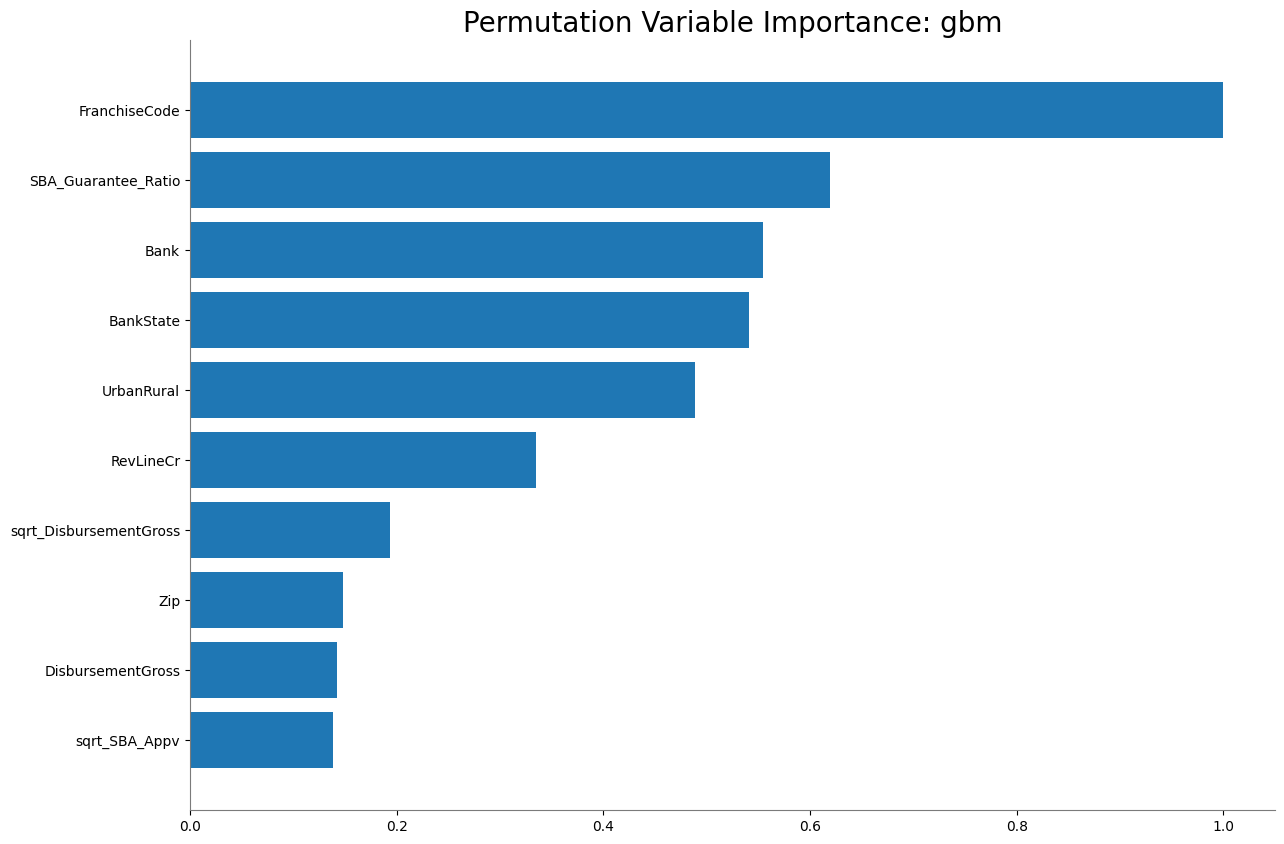

In [49]:
# calculate importance
permutation_varimp = best_model.permutation_importance(test, use_pandas=True)

# plot permutation importance (bar plot)
best_model.permutation_importance_plot(test);

#### Permutation Feature Importance Results Interpretation

This method assesses the impact of each feature on the prediction accuracy of the model. The importance is determined by the degree to which randomly shuffling the values of each feature reduces the accuracy of the model; a larger decrease signifies higher importance.

- **Most Influential Features:**
  - `FranchiseCode`: This feature has the highest importance score, indicating it has the most significant impact on the model's predictions. Changes in this feature likely lead to substantial changes in the output of the model.
  - `SBA_Guarantee_Ratio_`: The second most important feature, suggesting that the ratio of loan guaranteed by SBA has a strong influence on the model's predictions.
  - `Bank`: The bank is  also a top feature.

- **Other Notable Features:**
  - `Bank` and `UrbanRural`: These features show moderate importance and are likely to be considered relevant by the model during prediction.

- **Features with Lesser Importance:**
  - `DisbursementGross`, `Zip`, `sqrt_SBA_Appv`, and `sqrt_DisbursementGross` appear to have a smaller impact on model predictions compared to the top features.

#### Limitations
- The permutation variable importance method only indicates the magnitude of the impact that each feature has on the model's accuracy and does not provide directionality. This means that while we can identify which features are most influential, we cannot determine from this chart alone whether the influence is positive or negative on the prediction outcome.


### Probability Calculation for Accuracy Assessment

Computed the probabilities for classes 0 and 1 to identify the most and least accurate predictions. This approach facilitates a nuanced assessment of the model's predictive performance across different thresholds.


In [51]:
# Calculate the probabilities and make predictions
y_pred_h2o = best_model.predict(test[predictors])

# Apply threshold to get binary classification, convert to integer
threshold = 0.30616414255568053
y_pred = (y_pred_h2o['p1'] >= threshold).asfactor().asnumeric()

# Concatenate probabilities (rounded to 2 decimal places) and predictions with the test set
test = test.cbind([
    y_pred_h2o['p0'].round(2).set_names(['probability_0']),
    y_pred_h2o['p1'].round(2).set_names(['probability_1']),
    y_pred.set_names(['prediction'])
])

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [103]:
test.head(5)

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Region,NAICS_sector,NAICS_subsector,NAICS_industry_group,SBA_Guarantee_Ratio,LoanSizeCategory,sqrt_DisbursementGross,sqrt_GrAppv,sqrt_SBA_Appv,exp_NoEmp,NoEmp_RetainedJob,probability_0,probability_1,prediction
3,HURST,TX,76053,WILSHIRE BANK,CA,722213,4,Existing,0,4,1,Urban,Missing,N,140000,0,165000,82500,0,South,72,722,7222,0.5,Medium,374.166,406.202,287.228,54.5982,16,0.74,0.26,0
9,CHICO,CA,95926,UMPQUA BANK,OR,722213,10,Existing,0,10,1,Rural,Missing,N,92000,0,92000,78200,0,West,72,722,7222,0.85,Medium,303.315,303.315,279.643,22026.5,100,0.88,0.12,0
14,HEARNE,TX,77859,LOANS FROM OLD CLOSED LENDERS,DC,0,12,New,0,0,1,Undefined,N,N,500000,0,500000,375000,0,South,0,0,0,0.75,Large,707.107,707.107,612.372,162755,0,0.93,0.07,0
17,SOMERSET,PA,15501,UNITED CENTRAL BANK,TX,721110,8,New,0,8,22470,Rural,Missing,N,50000,0,50000,42500,0,Northeast,72,721,7211,0.85,Small,223.607,223.607,206.155,2980.96,64,0.9,0.1,0
18,PHILADELPHIA,PA,19144,WELLS FARGO BANK NATL ASSOC,PA,0,21,New,0,0,1,Undefined,Missing,N,100000,0,100000,50000,0,Northeast,0,0,0,0.5,Medium,316.228,316.228,223.607,1.31882e+09,0,0.96,0.04,0


### Shapley Value Computation for Model Interpretation

Calculated Shapley contributions for the first 10,000 observations in the test set using `best_model`, providing an explanation of feature contributions to individual predictions. Combined these values with the actual responses to facilitate a detailed interpretation of the model's decision-making process.


In [52]:
shapley_contribs = best_model.predict_contributions(test[0:10000,:])
shapley_contribs = test[response][0:10000,:].cbind(shapley_contribs)
shapley_contribs.head()

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


MIS_Status,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Region,NAICS_sector,NAICS_subsector,NAICS_industry_group,SBA_Guarantee_Ratio,LoanSizeCategory,sqrt_DisbursementGross,sqrt_GrAppv,sqrt_SBA_Appv,NoEmp_RetainedJob,BiasTerm
0,0.0261591,0.0520394,0.197616,-0.263508,0.122796,0.0969219,0.0350358,-0.0507985,-0.000832457,0.0213319,-0.152766,0.182216,0.0791657,-0.00441273,0.0833747,0,-0.0148013,0.0354807,0.0891798,0.0269533,0.125214,0.0530619,0.198962,0.0082208,0.0734941,-0.142146,0.0351705,0.0607545,-2.04741
0,0.0222842,0.109705,-0.0791822,-0.13854,-0.0669637,0.12699,-0.0565247,-0.0982516,-0.0843431,0.02668,-0.165386,0.236229,-0.025646,-0.00176345,-0.00785341,0,0.00130803,-0.0791912,-0.0911478,0.0244234,0.0630032,0.0582552,0.476545,0.00851539,-0.0889479,0.0308541,-0.145166,0.00769205,-2.04741
0,0.00570925,0.0320572,0.0342714,-0.151431,0.025387,0.0217308,0.000280259,0.189146,0.0420234,-0.0476107,-0.399776,-0.426832,-0.0108065,-0.00115059,0.0620909,0,-0.0136181,-0.0488356,0.0596032,0.0370739,-0.0707264,0.0105406,0.218401,-0.0287958,0.0861415,-0.0720768,-0.0808053,-0.0635066,-2.04741
0,-0.00760812,-0.0484903,-0.0417783,-0.0820356,0.0188747,0.0406624,-0.0462898,0.135856,-0.123263,0.074095,-0.21065,0.0102259,0.0511597,0.00046349,-0.0661409,0,0.036283,0.0575637,0.00819953,-0.136336,-0.118905,-0.0828304,0.492694,-0.0493841,-0.071857,0.035925,-0.0694066,0.0679943,-2.04741
0,0.0473794,-0.0189284,-0.0499028,-0.182983,-0.127963,0.0141666,-0.00991708,-0.373998,-0.00280813,-0.047194,-0.403924,-0.404369,0.131268,-0.0238555,-0.0178282,0,0.0123796,0.0410063,-0.00355373,0.0278287,-0.0585027,0.00894095,-0.0848127,0.0141026,0.00618748,-0.0492933,-0.0272459,-0.076267,-2.04741
1,0.0169979,0.216681,0.083841,0.366011,0.534723,-0.00851087,0.0835455,0.058333,0.0105415,0.0241324,0.802371,0.214761,0.107401,5.7004e-05,0.164976,0,0.0270359,0.209481,2.6659e-06,-0.0459093,-0.048662,-0.127968,0.114354,0.0743097,0.257885,0.20443,0.322467,0.0681698,-2.04741
1,-0.00122422,0.0739874,0.0986528,-0.191492,-0.299358,0.0201782,0.071166,-0.000227013,-0.0110649,0.00879611,0.327572,0.103223,0.154931,0.00226163,0.0066889,0,-0.0357324,-0.052877,-0.0538544,0.000508692,0.0606689,0.0961822,0.0399128,-0.0262618,0.0197029,-0.028656,-0.0147242,0.0486744,-2.04741
0,-0.060524,-0.0782746,0.0190855,-0.169708,-0.0833929,-0.0430118,-0.0746146,-0.00794788,-0.0230152,0.0364012,0.421657,0.173794,-0.0527319,-0.00323769,0.00857478,0,-0.00745866,0.10583,0.0585884,-0.0396022,-0.0365441,0.0202264,0.103749,0.0806853,0.166642,0.115211,0.183126,0.0197739,-2.04741
0,0.0133665,-0.108644,-0.0772679,-0.085145,-0.013325,0.019467,0.0423155,-0.0107148,0.00212814,-0.115312,-0.5114,-0.27574,0.0155919,0.00162503,-0.14076,0,-0.00802751,0.0770004,-0.0367096,0.0312147,-0.0401137,0.0295113,-0.438177,0.00487942,-0.0649797,0.00827572,0.0447214,-0.21496,-2.04741
1,-0.0059695,-0.0999622,-0.0359798,0.0199965,0.111533,0.0625553,0.0362058,-0.0108566,-0.0142064,0.0215208,-0.25764,0.242388,0.0710776,0.00316698,0.105826,0,0.0197892,0.124447,0.00834599,0.00830884,0.0621789,0.0791468,0.0792483,-0.0215852,0.0877781,0.0919044,0.150115,0.0889206,-2.04741


In [65]:
# load JS visualization code to notebook
shap.initjs()

In [67]:
# The function is to calculate Shapley values (contributions) and plot them for single record
def examine_indiv_reason_codes(record, model, use_matplotlib=True):

    shap_contribs = model.predict_contributions(record)

    col_mapping = {}
    for i in record.col_names:
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols

    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)

    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    X = record.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)

    return shap.force_plot(bias_term,
                           shap_contribs[shap_cols].values,
                           X[shap_cols].values,
                           shap_cols,
                           link="logit",
                           matplotlib=use_matplotlib
                          )

### Detailed Analysis of Individual Observations with Shapley Values

Conducted a focused analysis on individual records using Shapley values across four key scenarios. The scenarios are:

1. **Correct Identification of Label 0:** Analyzed instances where the model correctly predicted label 0 with high probability, indicating strong confidence in the prediction.
2. **Misidentification of Label 0 as Label 1:** Examined cases where label 0 was incorrectly predicted as label 1, focusing on instances with significant probability to understand key contributing factors to the misclassification.
3. **Correct Identification of Label 1:** Selected instances where the model accurately predicted label 1 with high probability, revealing the model's confidence in these predictions.
4. **Misidentification of Label 1 as Label 0:** Investigated cases where label 1 was wrongly predicted as label 0, particularly those with a high probability, to discern the primary drivers of these errors.


#### Label `0` is correctly identified

In [88]:
correct_0_max_prob = test[(test['MIS_Status'].asnumeric() == 0) & 
                                           (test['prediction'].asnumeric() == 0)].sort(by='probability_0', ascending=False)

examine_indiv_reason_codes(correct_0_max_prob[:1, :], best_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


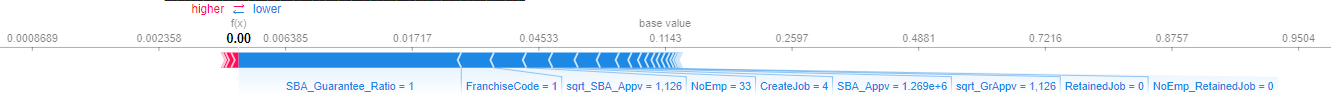

#### Key Feature Contributions to Correct Label `0` Prediction

1. **SBA Guarantee Ratio**: Full SBA loan coverage is a strong predictor for Label `0`.
2. **Franchise Code**: The binary indicator of a franchise significantly influences the prediction towards Label `0`.
3. **Square Root of SBA Approval**: Higher SBA approval amounts, even after transformation, tend to predict Label `0`.

The force plot indicates that these features positively contribute to the model's confidence in predicting Label `0`.

#### Label `0` is identified as `1`

In [94]:
wrong_0_max_prob = test[(test['MIS_Status'].asnumeric() == 0) & 
                        (test['prediction'].asnumeric() == 1)].sort(by='probability_1', ascending=False)

examine_indiv_reason_codes(wrong_0_max_prob[:1, :], best_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


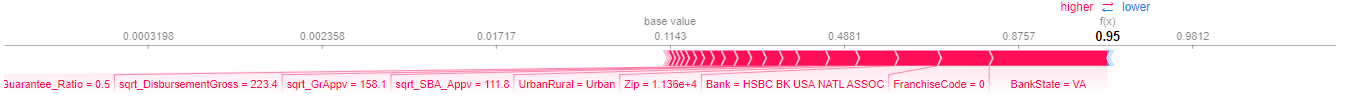

#### Key Feature Contributions to incorrect Label 0 Prediction as 1

1. **Bank Location**: Presence in Virginia (BankState = VA) strongly drives the prediction upwards.
2. **Franchise Code**: The franchise code of 1 significantly influences the prediction towards Label `1`.
3. **Specific Bank**: HSBC BANK USA positively influences the prediction.


#### Label `1` is identified as `0`

In [82]:
wrong_1_max_prob = test[(test['MIS_Status'].asnumeric() == 1) & 
                        (test['prediction'].asnumeric() == 0)].sort(by='probability_0', ascending=False)

examine_indiv_reason_codes(wrong_1_max_prob[0:1, :], best_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


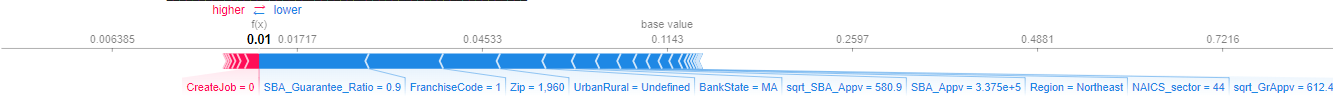

#### Key Feature Contributions to incorrect Label 1 Prediction as 0

1. **Job Creation**: Lack of job creation negatively affects the prediction.
2. **SBA Guarantee Ratio**: A higher SBA guarantee ratio has a positive impact.
3. **Franchise Status**: Being a franchise (FranchiseCode = 1) influences the prediction positively.


#### Label `1` is correctly identified

In [86]:
correct_1_max_prob = test[(test['MIS_Status'].asnumeric() == 1) & 
                                           (test['prediction'].asnumeric() == 1)].sort(by='probability_1', ascending=False)

examine_indiv_reason_codes(correct_1_max_prob[1:2, :], best_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


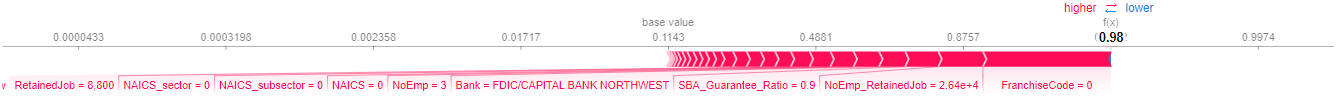

Key Feature Contributions to Correct Label `0` Prediction

1. **Franchise Status**: Non-franchise status (FranchiseCode = 0)
2. **Job Retention**: More jobs retained increase the prediction value.
3. **SBA Guarantee**: Higher SBA guarantee ratios are favorable for the prediction.


### Shapley Values Summary Plot Overview

The Shapley Values Summary Plot displays the following key information:

- **Feature Importance**: Each point on the summary plot represents a Shapley value for a feature and an instance. The position on the x-axis indicates the impact of that feature on the model's prediction for that instance.
- **Feature Value**: The color indicates the value of the feature, with cool colors representing lower values and warm colors representing higher values.
- **Impact Direction**: Features displayed on the right side of the plot have a positive impact on the prediction, while those on the left have a negative impact.
- **Aggregate Effect**: The density of the points can show the distribution of the impacts, with a higher density of points meaning more common effects for that feature across the dataset.

This plot helps us to understand which features are most important for a model and how individual feature values can lead to higher or lower predictions.


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


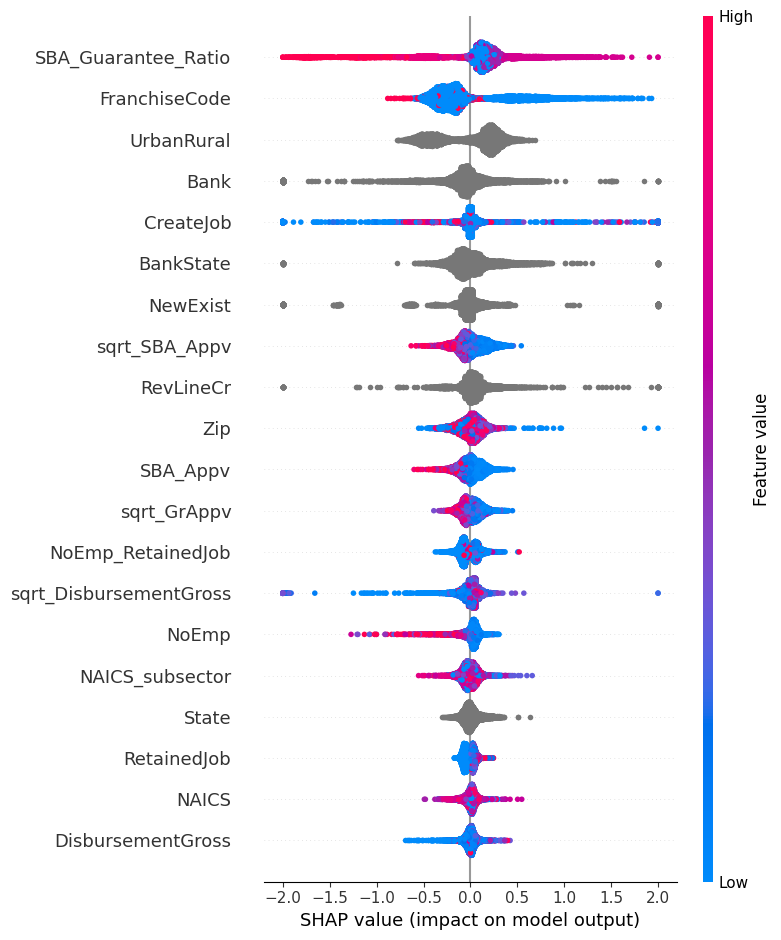

In [64]:
examine_all_reason_codes(test[:10000,:], best_model)

#### SHAP Summary Plot Interpretation

1. **Key Features**:
   - **SBA_Guarantee_Ratio**: Stands out as the top influencer, with higher values markedly increasing prediction values.
   - **FranchiseCode**: Also a top driver, where higher franchise codes contribute to elevated predictions.
   - **UrbanRural**: Presence in grey indicates a more neutral or varied impact on model outcomes across its values.

2. **Least Impactful Features**:
   - **RetainedJob, NAICS, DisbursementGross**: Positioned at the bottom, indicating a lower overall impact on the model's predictions.

3. **Color Significance**:
   - Colors represent feature values, with red signifying high and blue for low. The intensity and spread of color give insight into the distribution and influence of feature values.

4. **Importance in the Plot**:
   - More influential features appear higher on the chart, indicating their greater significance in affecting model outcomes.

5. **Data Subset**:
   - The plot reflects the SHAP values for a subset of 10,000 records from the test data, providing a sample view of model interpretation.

The SHAP Summary Plot visualizes the distribution and impact of feature contributions to model predictions, with color coding highlighting the range and influence of feature values.


## Residual Analysis

In [113]:
#Combine test and shapely contribution dataset
new_column_names = ['contrib_' + col for col in shapley_contribs.names]
shapley_contribs.set_names(new_column_names)

test_res = test[0:10000,:].cbind(shapley_contribs)
test_res.head()

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Region,NAICS_sector,NAICS_subsector,NAICS_industry_group,SBA_Guarantee_Ratio,LoanSizeCategory,sqrt_DisbursementGross,sqrt_GrAppv,sqrt_SBA_Appv,exp_NoEmp,NoEmp_RetainedJob,probability_0,probability_1,prediction,contrib_contrib_contrib_MIS_Status,contrib_contrib_contrib_City,contrib_contrib_contrib_State,contrib_contrib_contrib_Zip,contrib_contrib_contrib_Bank,contrib_contrib_contrib_BankState,contrib_contrib_contrib_NAICS,contrib_contrib_contrib_NoEmp,contrib_contrib_contrib_NewExist,contrib_contrib_contrib_CreateJob,contrib_contrib_contrib_RetainedJob,contrib_contrib_contrib_FranchiseCode,contrib_contrib_contrib_UrbanRural,contrib_contrib_contrib_RevLineCr,contrib_contrib_contrib_LowDoc,contrib_contrib_contrib_DisbursementGross,contrib_contrib_contrib_BalanceGross,contrib_contrib_contrib_GrAppv,contrib_contrib_contrib_SBA_Appv,contrib_contrib_contrib_Region,contrib_contrib_contrib_NAICS_sector,contrib_contrib_contrib_NAICS_subsector,contrib_contrib_contrib_NAICS_industry_group,contrib_contrib_contrib_SBA_Guarantee_Ratio,contrib_contrib_contrib_LoanSizeCategory,contrib_contrib_contrib_sqrt_DisbursementGross,contrib_contrib_contrib_sqrt_GrAppv,contrib_contrib_contrib_sqrt_SBA_Appv,contrib_contrib_contrib_NoEmp_RetainedJob,contrib_contrib_contrib_BiasTerm
3,HURST,TX,76053,WILSHIRE BANK,CA,722213,4,Existing,0,4,1,Urban,Missing,N,140000,0,165000,82500,0,South,72,722,7222,0.5,Medium,374.166,406.202,287.228,54.5982,16,0.74,0.26,0,0,0.0261591,0.0520394,0.197616,-0.263508,0.122796,0.0969219,0.0350358,-0.0507985,-0.000832457,0.0213319,-0.152766,0.182216,0.0791657,-0.00441273,0.0833747,0,-0.0148013,0.0354807,0.0891798,0.0269533,0.125214,0.0530619,0.198962,0.0082208,0.0734941,-0.142146,0.0351705,0.0607545,-2.04741
9,CHICO,CA,95926,UMPQUA BANK,OR,722213,10,Existing,0,10,1,Rural,Missing,N,92000,0,92000,78200,0,West,72,722,7222,0.85,Medium,303.315,303.315,279.643,22026.5,100,0.88,0.12,0,0,0.0222842,0.109705,-0.0791822,-0.13854,-0.0669637,0.12699,-0.0565247,-0.0982516,-0.0843431,0.02668,-0.165386,0.236229,-0.025646,-0.00176345,-0.00785341,0,0.00130803,-0.0791912,-0.0911478,0.0244234,0.0630032,0.0582552,0.476545,0.00851539,-0.0889479,0.0308541,-0.145166,0.00769205,-2.04741
14,HEARNE,TX,77859,LOANS FROM OLD CLOSED LENDERS,DC,0,12,New,0,0,1,Undefined,N,N,500000,0,500000,375000,0,South,0,0,0,0.75,Large,707.107,707.107,612.372,162755,0,0.93,0.07,0,0,0.00570925,0.0320572,0.0342714,-0.151431,0.025387,0.0217308,0.000280259,0.189146,0.0420234,-0.0476107,-0.399776,-0.426832,-0.0108065,-0.00115059,0.0620909,0,-0.0136181,-0.0488356,0.0596032,0.0370739,-0.0707264,0.0105406,0.218401,-0.0287958,0.0861415,-0.0720768,-0.0808053,-0.0635066,-2.04741
17,SOMERSET,PA,15501,UNITED CENTRAL BANK,TX,721110,8,New,0,8,22470,Rural,Missing,N,50000,0,50000,42500,0,Northeast,72,721,7211,0.85,Small,223.607,223.607,206.155,2980.96,64,0.9,0.1,0,0,-0.00760812,-0.0484903,-0.0417783,-0.0820356,0.0188747,0.0406624,-0.0462898,0.135856,-0.123263,0.074095,-0.21065,0.0102259,0.0511597,0.00046349,-0.0661409,0,0.036283,0.0575637,0.00819953,-0.136336,-0.118905,-0.0828304,0.492694,-0.0493841,-0.071857,0.035925,-0.0694066,0.0679943,-2.04741
18,PHILADELPHIA,PA,19144,WELLS FARGO BANK NATL ASSOC,PA,0,21,New,0,0,1,Undefined,Missing,N,100000,0,100000,50000,0,Northeast,0,0,0,0.5,Medium,316.228,316.228,223.607,1.31882e+09,0,0.96,0.04,0,0,0.0473794,-0.0189284,-0.0499028,-0.182983,-0.127963,0.0141666,-0.00991708,-0.373998,-0.00280813,-0.047194,-0.403924,-0.404369,0.131268,-0.0238555,-0.0178282,0,0.0123796,0.0410063,-0.00355373,0.0278287,-0.0585027,0.00894095,-0.0848127,0.0141026,0.00618748,-0.0492933,-0.0272459,-0.076267,-2.04741
19,RANCHO MARGARITA,CA,92688,CAPITAL ONE BK (USA) NATL ASSO,VA,611620,1,Existing,0,1,0,Urban,Y,N,65889,0,25000,12500,1,West,61,611,6116,0.5,Medium,256.689,158.114,111.803,2.71828,1,0.16,0.84,1,1,0

### Calculate deviance residuals for binomial classification

For binomial classification, deviance residuals are related to the logloss cost function. Like analyzing `y−ŷ` 

In [114]:
# use Pandas for adding columns and plotting
yhat = 'probability_0'
y = 'MIS_Status'

test_res = test_res.as_data_frame()
test_res['s'] = 1
test_res.loc[test_res[y] == 0, 's'] = -1
test_res['residual_0'] = test_res['s'] * np.sqrt(-2*(test_res[y]*np.log(test_res[yhat]) +
                                                                 ((1 - test_res[y])*np.log(1 - test_res[yhat]))))
test_res = test_res.drop('s', axis=1)

In [116]:
test_res.head(5)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Region,NAICS_sector,NAICS_subsector,NAICS_industry_group,SBA_Guarantee_Ratio,LoanSizeCategory,sqrt_DisbursementGross,sqrt_GrAppv,sqrt_SBA_Appv,exp_NoEmp,NoEmp_RetainedJob,probability_0,probability_1,prediction,contrib_contrib_contrib_MIS_Status,contrib_contrib_contrib_City,contrib_contrib_contrib_State,contrib_contrib_contrib_Zip,contrib_contrib_contrib_Bank,contrib_contrib_contrib_BankState,contrib_contrib_contrib_NAICS,contrib_contrib_contrib_NoEmp,contrib_contrib_contrib_NewExist,contrib_contrib_contrib_CreateJob,contrib_contrib_contrib_RetainedJob,contrib_contrib_contrib_FranchiseCode,contrib_contrib_contrib_UrbanRural,contrib_contrib_contrib_RevLineCr,contrib_contrib_contrib_LowDoc,contrib_contrib_contrib_DisbursementGross,contrib_contrib_contrib_BalanceGross,contrib_contrib_contrib_GrAppv,contrib_contrib_contrib_SBA_Appv,contrib_contrib_contrib_Region,contrib_contrib_contrib_NAICS_sector,contrib_contrib_contrib_NAICS_subsector,contrib_contrib_contrib_NAICS_industry_group,contrib_contrib_contrib_SBA_Guarantee_Ratio,contrib_contrib_contrib_LoanSizeCategory,contrib_contrib_contrib_sqrt_DisbursementGross,contrib_contrib_contrib_sqrt_GrAppv,contrib_contrib_contrib_sqrt_SBA_Appv,contrib_contrib_contrib_NoEmp_RetainedJob,contrib_contrib_contrib_BiasTerm,residual_0
0,3,HURST,TX,76053,WILSHIRE BANK,CA,722213,4,Existing,0,4,1,Urban,Missing,N,140000,0,165000,82500,0,South,72,722,7222,0.50,Medium,374.165739,406.201920,287.228132,5.459815e+01,16,0.74,0.26,0,0,0.026159,0.052039,0.197616,-0.263508,0.122796,0.096922,0.035036,-0.050799,-0.000832,0.021332,-0.152766,0.182216,0.079166,-0.004413,0.083375,0,-0.014801,0.035481,0.089180,0.026953,0.125214,0.053062,0.198962,0.008221,0.073494,-0.142146,0.035171,0.060754,-2.047415,-1.641386
1,9,CHICO,CA,95926,UMPQUA BANK,OR,722213,10,Existing,0,10,1,Rural,Missing,N,92000,0,92000,78200,0,West,72,722,7222,0.85,Medium,303.315018,303.315018,279.642629,2.202647e+04,100,0.88,0.12,0,0,0.022284,0.109705,-0.079182,-0.138540,-0.066964,0.126990,-0.056525,-0.098252,-0.084343,0.026680,-0.165386,0.236229,-0.025646,-0.001763,-0.007853,0,0.001308,-0.079191,-0.091148,0.024423,0.063003,0.058255,0.476545,0.008515,-0.088948,0.030854,-0.145166,0.007692,-2.047415,-2.059254
2,14,HEARNE,TX,77859,LOANS FROM OLD CLOSED LENDERS,DC,0,12,New,0,0,1,Undefined,N,N,500000,0,500000,375000,0,South,0,0,0,0.75,Large,707.106781,707.106781,612.372436,1.627548e+05,0,0.93,0.07,0,0,0.005709,0.032057,0.034271,-0.151431,0.025387,0.021731,0.000280,0.189146,0.042023,-0.047611,-0.399776,-0.426832,-0.010807,-0.001151,0.062091,0,-0.013618,-0.048836,0.059603,0.037074,-0.070726,0.010541,0.218401,-0.028796,0.086142,-0.072077,-0.080805,-0.063507,-2.047415,-2.306192
3,17,SOMERSET,PA,15501,UNITED CENTRAL BANK,TX,721110,8,New,0,8,22470,Rural,Missing,N,50000,0,50000,42500,0,Northeast,72,721,7211,0.85,Small,223.606798,223.606798,206.155281,2.980958e+03,64,0.90,0.10,0,0,-0.007608,-0.048490,-0.041778,-0.082036,0.018875,0.040662,-0.046290,0.135856,-0.123263,0.074095,-0.210650,0.010226,0.051160,0.000463,-0.066141,0,0.036283,0.057564,0.008200,-0.136336,-0.118905,-0.082830,0.492694,-0.049384,-0.071857,0.035925,-0.069407,0.067994,-2.047415,-2.145966
4,18,PHILADELPHIA,PA,19144,WELLS FARGO BANK NATL ASSOC,PA,0,21,New,0,0,1,Undefined,Missing,N,100000,0,100000,50000,0,Northeast,0,0,0,0.50,Medium,316.227766,316.227766,223.606798,1.318816e+09,0,0.96,0.04,0,0,0.047379,-0.018928,-0.049903,-0.182983,-0.127963,0.014167,-0.009917,-0.373998,-0.002808,-0.047194,-0.403924,-0.404369,0.131268,-0.023856,-0.017828,0,0.012380,0.041006,-0.003554,0.027829,-0.058503,0.008941,-0.084813,0.014103,0.006187,-0.049293,-0.027246,-0.076267,-2.047415,-2.537272


In [117]:
test_res = test_res.sort_values(by='residual_0', ascending=False).reset_index(drop=True)
test_res[["index","MIS_Status", "probability_0","residual_0"]].head(5)

,index,MIS_Status,probability_0,residual_0
0,22658,1,0.05,2.447747
1,26853,1,0.05,2.447747
2,26459,1,0.06,2.372092
3,48073,1,0.06,2.372092
4,5080,1,0.06,2.372092


## Project Summary and Conclusion

### Summary of Work
Throughout this project, we performed a detailed analysis of the Small Business Administration (SBA) loan dataset. Our work involved data cleaning, exploratory data analysis (EDA), feature engineering, and the development and validation of predictive models. We focused on identifying patterns and factors that influence loan outcomes to predict defaults effectively.

### Summary of Findings
Our findings revealed several key factors that significantly impact loan performance. For instance, the SBA Guarantee Ratio and Franchise Code were among the top predictors, suggesting that guaranteed loans and franchise-related businesses exhibit distinct loan behaviors. Urban versus rural distinctions also contributed to variations in loan performance.

### Summary of Model Performance
The predictive model, a gradient boosting machine (GBM), was rigorously tested and validated. It demonstrated robust performance with an accuracy of [0.844]. The model's performance was further interpreted using SHAP values, which highlighted the most influential features driving predictions.

In conclusion, the project has provided valuable insights that could help improve loan issuance strategies, reduce default rates, and inform policy adjustments. Our model serves as a solid foundation for further refinement and operational deployment.


## Future Work

- **Enhanced Feature Engineering**: Investigate the creation of more informative features or explore non-linear feature transformations to better capture the complex relationships within the data.

- **Advanced Algorithms**: Test with more sophisticated models, such as Deep Learning architectures, which might be better at capturing non-linearities and interactions.

- **Class Imbalance Strategies**: Apply more nuanced techniques to address class imbalance, such as advanced oversampling methods, cost-sensitive learning, or anomaly detection approaches for the minority class.

- **Ensemble Methods**: Leverage the strengths of various models through ensemble techniques that can lead to more accurate and robust predictions.
